***Data Analysis Interview Challenge***

This is your chance to wow us with creative and rigorous solutions! Please include your code at
the end of your submission, or in a separate file. We also accept incomplete solutions.

**Part 1 ‑ Exploratory data analysis**

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


In [53]:
# import necessary packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime


In [54]:
# load json data
df = pd.read_json('logins.json')

# analyze first few rows
print(df.head())

#check min date and max date
print(df.login_time.min())
print(df.login_time.max())


           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
1970-01-01 20:12:16
1970-04-13 18:57:38


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [56]:


#index to resample
df = df.set_index(['login_time'])
df = df.sort_index() 
# add 'count' column
df['count'] = 0
df = df.resample('15T').count()
df = df.reset_index()
df.head()

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


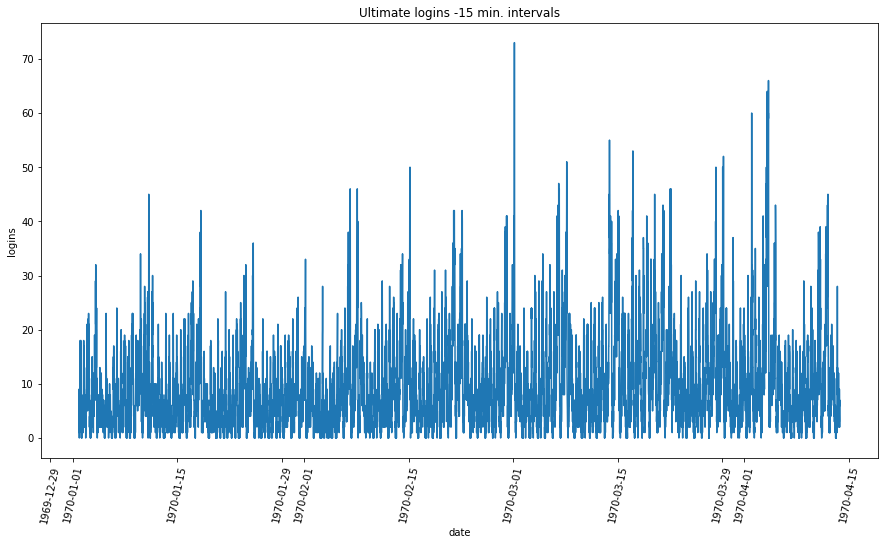

In [57]:
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(15,8))
sns.lineplot(x="login_time", y="count",   data=df);
plt.xticks(rotation = 78)
plt.xlabel('date')
plt.ylabel('logins')
plt.title('Ultimate logins -15 min. intervals');

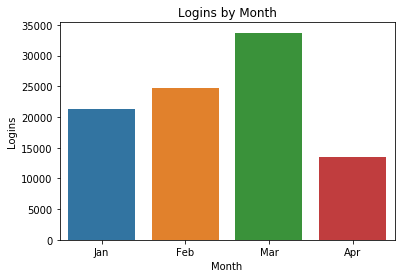

In [58]:
# create a  new column month
df['month'] = df.login_time.dt.month

# sort by count
df_m = df.sort_values(by = 'count', ascending = False)

# extract the day of week and count, then group by day and sum all logins
df_m = df_m[['month', 'count']]
df_m = df_m.groupby('month').sum().reset_index()

# names of month 
df_m.month = ["Jan", "Feb","Mar","Apr"]

# bar plot
sns.barplot(x = 'month', y = 'count', data = df_m)
plt.xlabel('Month')
plt.ylabel('Logins')
plt.title('Logins by Month');

Looks like there were more logins during the month of March compared to January, February and April.

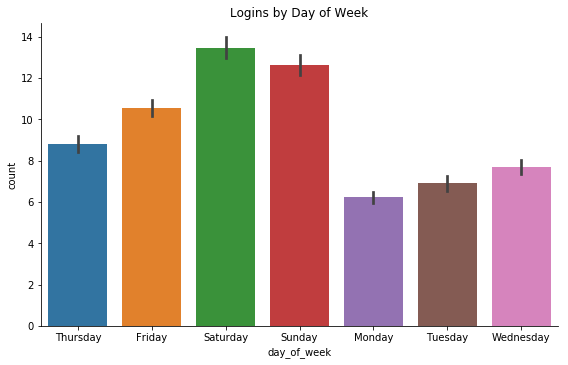

In [59]:
# create a  new column day of week
df['day_of_week'] = df.login_time.dt.weekday_name

g =sns.catplot(x='day_of_week', y="count" , data = df,  kind = "bar",aspect=1.6) ;
plt.title('Logins by Day of Week');

Login peaks on Saturday. Weekends looks busier than other days in terms of logins

[]

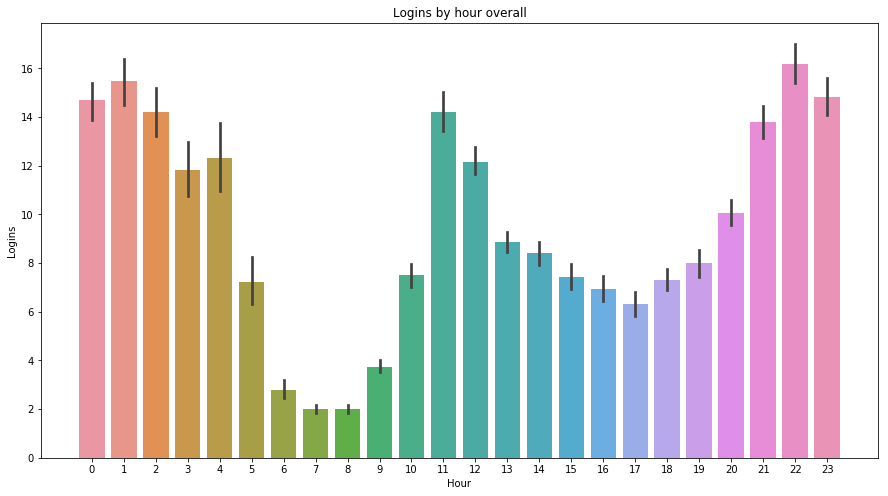

In [60]:
df['hour'] = df.login_time.dt.hour

plt.figure(figsize=(15,8))
# bar plot
sns.barplot(x = 'hour',y = 'count', data = df)
plt.xlabel('Hour')
plt.ylabel('Logins')
#ax.set(xticks=range(7), xticklabels=names)
plt.title('Logins by hour overall');
plt.plot()

The daily login counts  lowest in the early morning (6am-9am), bounches up to its first spike around lunch time (11am-12pm), followed by a graduate decline in the afternoon till 5pm; it gradually rises back up in the early evening and reaches its second peak in late evening to midnight (21pm-3am). 

<Figure size 1080x936 with 0 Axes>

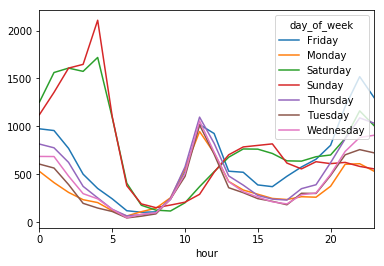

In [61]:
#create a plot that has the hour of the day (from 0 to 24) on the x-axis and count on the y axis segregated by day of the week
df1 = df.groupby([df['hour'], 'day_of_week'])['count'].sum().unstack()
plt.figure(figsize=(15,13));
df1.plot();

Looks like the peak times are from 9pm - 4am and again at 10 am to 12 pm. The usage on Saturday and Sunday looks identical for the most part from 12:00 am till 3 PM.

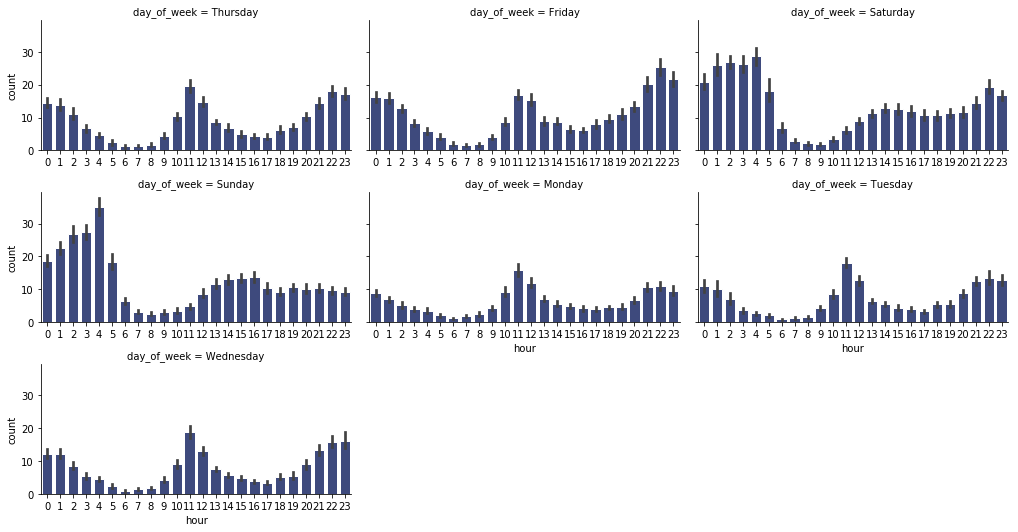

In [62]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
df1.unstack()
g = sns.FacetGrid(df, col="day_of_week", margin_titles=True, height=2.5,sharex=False,col_wrap=3,aspect=1.9, sharey = True) 
g.map(sns.barplot,'hour','count',color="#334488", edgecolor="white")
      

The busiest times are early Saturday & Sunday mornings compared to other days. 
Logins are slower during the nights and early mornings  during every day of the week.The login count at 15-minute intervals sees the lowest on Monday, and gradually ramps up throughout the week, and reaches its peak on weekends. Login counts on Saturday are slightly higher than those on Sunday. There are also peaks around lunch hours on  Mondays - Fridays.

__Part 2 ‑ Experiment and metrics design__

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

__Solution:__
    
My proposed key measure of success would be:

 1) increased  amount of time spent by Gotham city drivers in city 'Metropolis'
 2) increased amount of time spent by  'Metropolis' drivers  in city 'Gotham' 

I would recommend performing an A/B test wherein a portion of the drivers from each city are offered reimbursement and the remaining drivers (control group) continue to operate without being reimbursed for tolls. I would perform a  t−test keeping a confidence level of 95%, where the null hypothesis ($H_0$) is that reimbursing drivers for tolls does not have a statistically-significant impact on Ultimate's net profits whereas alternate hypothesis ($H_a$) states that reimbursing drivers for tolls does have a statistically-significant impact on Ultimate's net profits.

$$H_0: \mu_(experiment) - \mu_(control) = 0$$
$$H_a: \mu_(experiment) - \mu_(control) \neq 0$$

We will compute the t-statistics and use $t$ table to find the p-value and draw conclusion. If we get a small p-value ≤ 0.05, since the confidence interval is 95%, it indicates strong evidence against the null hypothesis, so we reject the null hypothesis. Else, we fail to reject the null hypothesis.

The potential caveats are:

Since the city 'Gotham' is mostly active at night,with no bridge toll, 'Gotham'city drivers might be willing to go to city 'Metropolis' during the day for more riders, resulting in a significant difference in this group.But city 'Metropolis' is mostly active during the day, Metropolis'
drivers might not be willing to serve city 'Gotham' at night, especially if they prefer to stay home during night time. 

__Part 3 ‑ Predictive modeling__

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).


__Data description__

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYY MM DD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

__Analysis:__

In [63]:
import json

file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


As we can see, the columns 'avg_rating_by_driver', 'avg_rating_of_driver' and 'phone' has missing data.

__Data Wrangling__

In [65]:
# convert date-related columns to datetime format
df['last_trip_date'] = pd.to_datetime(df.last_trip_date, format='%Y-%m-%d')
df['signup_date'] = pd.to_datetime(df.signup_date, format='%Y-%m-%d')

"""Missing ratings: fill missing values with averages"""

df.avg_rating_by_driver = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver).mean()
df.avg_rating_of_driver = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver).mean()
# fill in missing values as 'not_available' for the categorical column 'phone'
df.phone = df.phone.fillna('not_available')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [69]:
earliest_signup = df.signup_date.min()
latest_signup = df.signup_date.max()
signup_ct = df.signup_date.count()
last_trip = df.last_trip_date.max()

print('There were {} signups between {} and {}'.format(signup_ct, earliest_signup, latest_signup))
print('latest time in the "last_trip_date" column: {}'.format(last_trip))

There were 50000 signups between 2014-01-01 00:00:00 and 2014-01-31 00:00:00
latest time in the "last_trip_date" column: 2014-07-01 00:00:00


As shown, the 'signup_date' is indeed between '2014-01-01 00:00:00' and '2014-01-31 00:00:00', that is, all users belong to the cohort of January, 2014.
In addition, the latest time in the 'last_trip_date' column was '2014-07-01 00:00:00', therefore we assume the data was pulled at least six months after signup.

Compute the 'retained' users:

Since the data was pulled on 2014-07-01, therefore a user is considered 'retained' if the user took a trip within the 30 days prior to 2014-07-01.

In [72]:
# mark users 'retained' in df if rode in last 30 days
df['retained'] =  df.last_trip_date >= '2014-06-01 00:00:00'
df.head(2)


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,4.778158,4.601559,1.1,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,4.778158,4.601559,1.0,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False


In [75]:
# compute the fraction of user retained
df.retained.sum()/len(df)

0.37608

As we can see, only 37.6% of all users signed up in January, 2014 are retained six month later.

__EDA:__

Correlation of user retention with numerical columns:

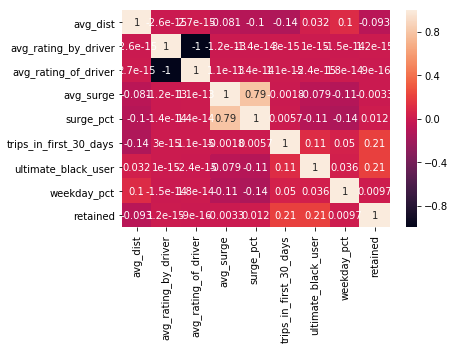

In [73]:
sns.heatmap(df.corr(),annot=True);

As shown, among the numerical columns, 'trips_in_first_30_days' shows the most positive correlations whereas the 'avg_dist' shows the most negative correlations.

Correlation of user retention with categorical columns:

Text(0.5, 1.0, 'Retained based on counts by phone type')

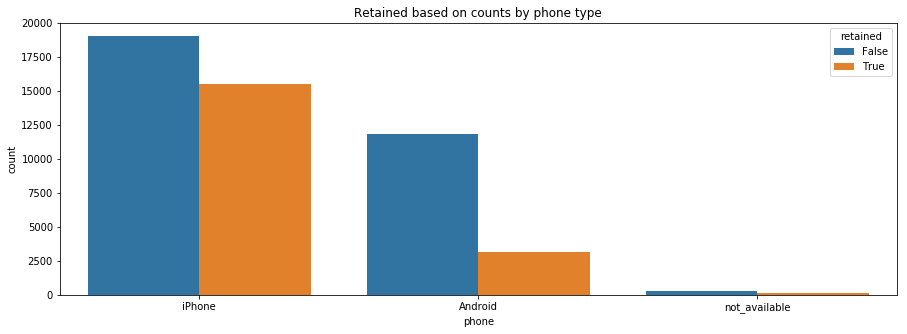

In [89]:
# correlation between 'retained' and 'phone'
plt.figure(figsize=(15,5))
sns.countplot(x='phone', data=df, hue='retained');
plt.title("Retained based on counts by phone type")

In [90]:
pr = df[['retained', 'phone']].groupby('phone').sum().reset_index()


all_android = df[df.phone == 'Android'].phone.count()
all_android

all_iphone = df[df.phone == 'iPhone'].phone.count()
all_iphone

pr['percent'] = 0

pr.iloc[0, 2] = pr.loc[0, 'retained'] / all_android * 100
pr.iloc[1, 2] = pr.loc[1, 'retained'] / all_iphone * 100

pr

,phone,retained,percent
0,Android,3146.0,20.942617
1,iPhone,15525.0,44.893297
2,not_available,133.0,0.000000


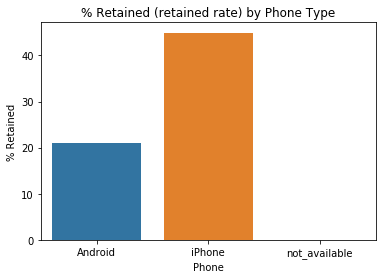

In [91]:
sns.barplot(x = 'phone', y = 'percent', data = pr)
plt.xlabel('Phone')
plt.ylabel('% Retained')
plt.title('% Retained (retained rate) by Phone Type');

As shown, user retention is strongly correlated to the type of phone used by the user:
Iphone users show a much higher retention rate than Android users.

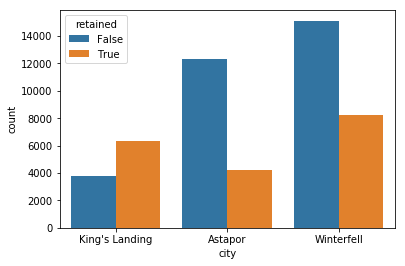

In [92]:
# correlation between 'retained' and 'city'
sns.countplot(x='city',  hue='retained',data=df);

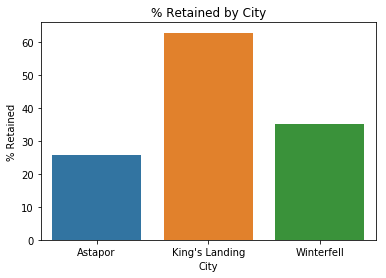

In [93]:
city = df[['retained', 'city']].groupby('city').sum().reset_index()

city_total = df[['retained', 'city']].groupby('city').count().reset_index()

city = city.merge(city_total, on = 'city')
city.columns = ['city', 'retained', 'total']
city['percent'] = city.retained / city.total * 100
city

sns.barplot(x = 'city', y = 'percent', data = city)
plt.xlabel('City')
plt.ylabel('% Retained')
plt.title('% Retained by City');

As shown, user retention is also strongly correlated to the city the user signed up in:
    
King's landing gives the highest retention rate among the three cities, whereas Astapor is the lowest.

__Modeling:__

In [96]:
df = df.drop(['last_trip_date', 'signup_date'], axis = 1)
# extract features X and target variable y
X = pd.get_dummies(df.drop('retained',axis=1), drop_first=True)
y = df.retained

X.head(2)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,city_King's Landing,city_Winterfell,phone_iPhone,phone_not_available
0,3.67,4.778158,4.601559,1.1,15.4,4,True,46.2,1,0,1,0
1,8.26,4.778158,4.601559,1.0,0.0,0,False,50.0,0,0,0,0


In [99]:
# train-test split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Dummy Classifier accuracy: 0.5334


              precision    recall  f1-score   support

       False       0.62      0.63      0.63      7799
        True       0.38      0.37      0.37      4701

   micro avg       0.53      0.53      0.53     12500
   macro avg       0.50      0.50      0.50     12500
weighted avg       0.53      0.53      0.53     12500



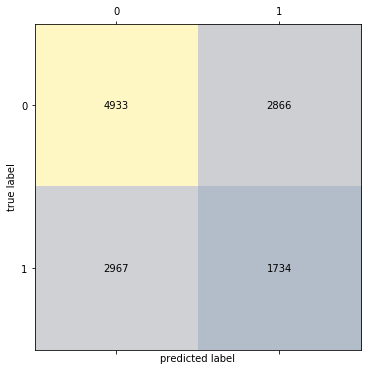

In [102]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier

# instantiate and fit a dummy classifier
dummy = DummyClassifier(random_state = 42)
dummy.fit(X_train, y_train)

# make predictions
y_pred = dummy.predict(X_test)

# SCORING
# accuracy
dummy_accuracy = dummy.score(X_test, y_test)
print('Dummy Classifier accuracy: {:.4f}\n\n'.format(dummy_accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.cividis, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

Logistic Regression:

In [105]:
from sklearn.linear_model import LogisticRegression
# instantiate & fit model
model = LogisticRegression(solver = 'liblinear',random_state = 42)
model.fit(X_train, y_train)

# make predictions on test features
y_pred = model.predict(X_test)

# score predictions
accuracy = model.score(X_test, y_test)
print('Logistic Regression Accuracy:\t{:.4f}\n'.format(accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
cm

Logistic Regression Accuracy:	0.7144

              precision    recall  f1-score   support

       False       0.74      0.85      0.79      7799
        True       0.66      0.50      0.57      4701

   micro avg       0.71      0.71      0.71     12500
   macro avg       0.70      0.67      0.68     12500
weighted avg       0.71      0.71      0.70     12500

Confusion Matrix:


array([[6603, 1196],
       [2374, 2327]], dtype=int64)

In [ ]:
___Tuned Logistic Regression:___

Best penalty: l1
Best C: 0.01
Tuned Accuracy:	0.7150

              precision    recall  f1-score   support

       False       0.73      0.86      0.79      7799
        True       0.67      0.48      0.56      4701

   micro avg       0.71      0.71      0.71     12500
   macro avg       0.70      0.67      0.67     12500
weighted avg       0.71      0.71      0.70     12500



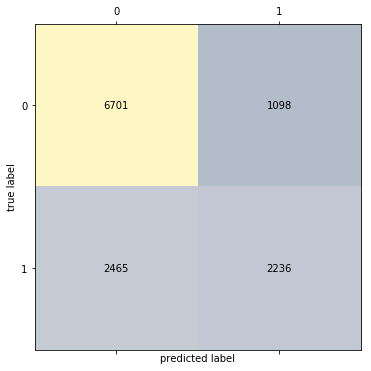

In [108]:
# create a params dict
penalty = ['l1', 'l2']
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
hyperparameters = dict(C = C, penalty = penalty)

# instantiate & fit grid search
gridsearch = GridSearchCV(model, hyperparameters, cv = 5, verbose = 0)
best_model = gridsearch.fit(X_train, y_train)

# print the best hyperparameters
best_penalty = best_model.best_estimator_.get_params()['penalty']
best_C = best_model.best_estimator_.get_params()['C']
print('Best penalty: {}'.format(best_penalty))
print('Best C: {}'.format(best_C))

# build & fit a tuned model
tuned_model = LogisticRegression(solver = 'liblinear',C = best_C, penalty = best_penalty)
tuned_model.fit(X_train, y_train)

# make predictions on test features
y_pred = tuned_model.predict(X_test)

# score predictions
accuracy = tuned_model.score(X_test, y_test)
print('Tuned Accuracy:\t{:.4f}\n'.format(accuracy))

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cm, cmap = plt.cm.cividis, alpha = 0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label');

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [130]:
# initiate the score table
index = ['LogisticRegression','SVC','RandomForestClassifier','GradientBoostingClassifier','Decision Tree']
score_table = pd.DataFrame(index = index, columns= ['accuracy_train','f1_score_train','accuracy_test','f1_score_test'])

# define function for plotting the results
def compute_log_result(algo, pred_train, pred_test):
    """compute and log the performance for both training and test sets"""
    
    # compute the performance  
    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_test = accuracy_score(y_test, pred_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    
    # log the performance
    score_table.loc[algo,:] = accuracy_train, f1_train, accuracy_test, f1_test
    
    # compute confusion matrix and print
    print("Classification results based on the testset:\n", classification_report(y_test, pred_test))
    # confusion matrix
    cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
    # score predictions

    print('Accuracy:\t{:.4f}\n'.format(accuracy_test))

    fig, ax = plt.subplots(figsize = (6, 6))
    ax.matshow(cm, cmap = plt.cm.cividis, alpha = 0.3)
    print("Confusion Matrix:")
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label');

Logistic regression model with default parameters
Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.74      0.85      0.79      7799
        True       0.66      0.50      0.57      4701

   micro avg       0.71      0.71      0.71     12500
   macro avg       0.70      0.67      0.68     12500
weighted avg       0.71      0.71      0.70     12500

Accuracy:	0.7145

Confusion Matrix:


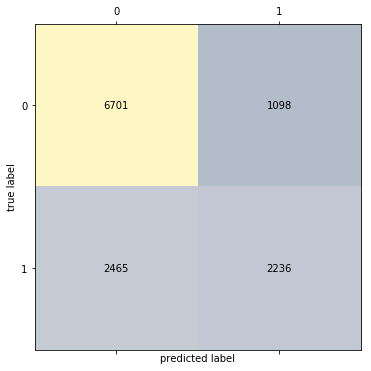

In [131]:
# fit logistic regression model with default parameters
print("Logistic regression model with default parameters")
logit = Pipeline([('scaler', StandardScaler()),('logit',LogisticRegression(solver = 'liblinear', random_state = 42))])
logit.fit(X_train, y_train)
pred_train = logit.predict(X_train)
pred_test = logit.predict(X_test)

# logging of model performance
compute_log_result("LogisticRegression", pred_train, pred_test)


support vector machine model with default parameters:
Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.77      0.86      0.81      7799
        True       0.71      0.58      0.64      4701

   micro avg       0.75      0.75      0.75     12500
   macro avg       0.74      0.72      0.72     12500
weighted avg       0.75      0.75      0.75     12500

Accuracy:	0.7522

Confusion Matrix:


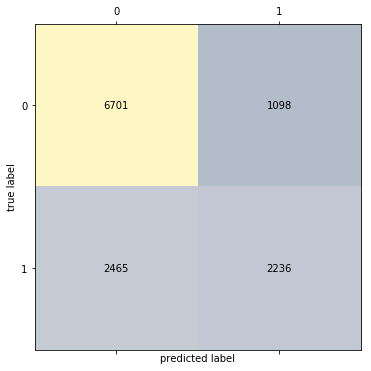

In [132]:
# fit support vector machine model with default parameters
print("support vector machine model with default parameters:")
svc = Pipeline([('scaler', StandardScaler()),('svc', SVC(gamma = 'auto'))])
svc.fit(X_train, y_train)
pred_train = svc.predict(X_train)
pred_test = svc.predict(X_test)

# logging of model performance
compute_log_result("SVC", pred_train, pred_test)

Random forest model with default parameters
Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.79      0.78      0.79      7799
        True       0.64      0.65      0.65      4701

   micro avg       0.73      0.73      0.73     12500
   macro avg       0.72      0.72      0.72     12500
weighted avg       0.73      0.73      0.73     12500

Accuracy:	0.7334

Confusion Matrix:


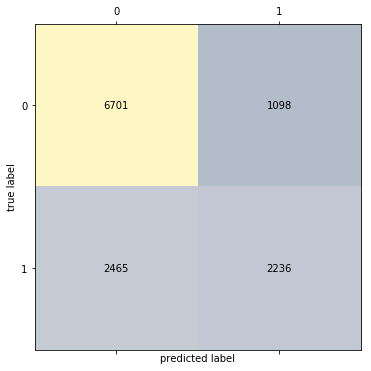

In [133]:
# fit random forest model with default parameters
print("Random forest model with default parameters")
rfc = Pipeline([('scaler', StandardScaler()),('rfc', RandomForestClassifier(class_weight='balanced',n_estimators = 100))]) # set class_weight='balanced' to adjust for the imbalanced classes
rfc.fit(X_train, y_train)
pred_train = rfc.predict(X_train)
pred_test = rfc.predict(X_test)

compute_log_result("RandomForestClassifier", pred_train, pred_test)

Gradientboosting model with default parameters:
Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.80      0.86      0.83      7799
        True       0.73      0.65      0.69      4701

   micro avg       0.78      0.78      0.78     12500
   macro avg       0.77      0.75      0.76     12500
weighted avg       0.78      0.78      0.78     12500

Accuracy:	0.7784

Confusion Matrix:


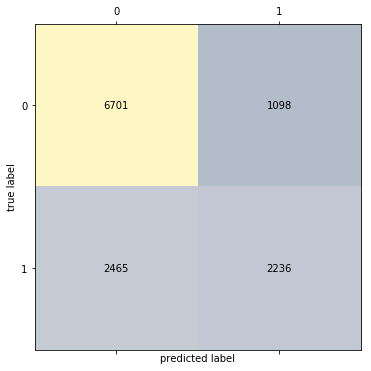

In [134]:
# fit gradientboosting model with default parameters
print("Gradientboosting model with default parameters:")
gbc = Pipeline([('scaler', StandardScaler()),('gbc', GradientBoostingClassifier())]) # set class_weight='balanced' to adjust for the imbalanced classes
gbc.fit(X_train, y_train)
pred_train = gbc.predict(X_train)
pred_test = gbc.predict(X_test)

compute_log_result("GradientBoostingClassifier", pred_train, pred_test)

DecisionTreeClassifier
Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.76      0.77      0.77      7799
        True       0.62      0.60      0.61      4701

   micro avg       0.71      0.71      0.71     12500
   macro avg       0.69      0.69      0.69     12500
weighted avg       0.71      0.71      0.71     12500

Accuracy:	0.7087

Confusion Matrix:


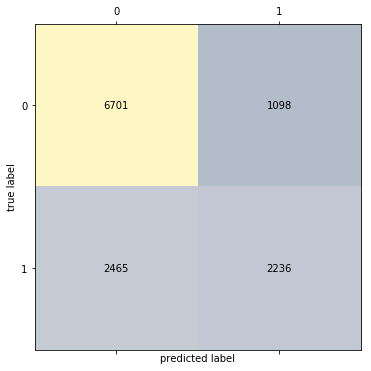

In [137]:


from sklearn.tree import DecisionTreeClassifier
print("DecisionTreeClassifier")
dtc = Pipeline([('scaler', StandardScaler()),('dtc', DecisionTreeClassifier(random_state = 42))])
dtc.fit(X_train, y_train)
pred_train = dtc.predict(X_train)
pred_test = dtc.predict(X_test)

compute_log_result("Decision Tree", pred_train, pred_test)

In [138]:
print(score_table)

                           accuracy_train f1_score_train accuracy_test  \
LogisticRegression               0.717413       0.570676       0.71448   
SVC                              0.761253       0.645356       0.75216   
RandomForestClassifier           0.986933       0.982622       0.73344   
GradientBoostingClassifier       0.780827       0.688403        0.7784   
Decision Tree                    0.987013       0.982457       0.70872   
DecisionTreeClassifier           0.987013       0.982457       0.70872   

                           f1_score_test  
LogisticRegression              0.566079  
SVC                             0.636811  
RandomForestClassifier          0.646735  
GradientBoostingClassifier      0.686722  
Decision Tree                   0.607439  
DecisionTreeClassifier          0.607439  


____Optimization:___

As we can see, with the default parameters, GradientBoostingClassifier gives the best performance with respect to accuracy in the test set. Therefore, parameter tuning of the GradientBoostingClassifier model is further performed using gridsearch cross validation.

In [139]:
# Grid search of parameters to improve GradientBoostingClassifer model
parameters = {'gbc__n_estimators': np.arange(500,1000,100), 'gbc__max_features':[None,'sqrt','log2']}
gbc_cv = GridSearchCV(gbc, parameters, scoring='accuracy', cv=5)
gbc_cv.fit(X_train, y_train)
print('Best parameters:', gbc_cv.best_params_)
print('Corresponding accuracy score:', gbc_cv.best_score_)

Best parameters: {'gbc__max_features': 'log2', 'gbc__n_estimators': 900}
Corresponding accuracy score: 0.7850133333333333


Classification results based on the testset:
               precision    recall  f1-score   support

       False       0.81      0.86      0.83      7799
        True       0.74      0.66      0.70      4701

   micro avg       0.79      0.79      0.79     12500
   macro avg       0.78      0.76      0.77     12500
weighted avg       0.78      0.79      0.78     12500

Accuracy:	0.7863

Confusion Matrix:


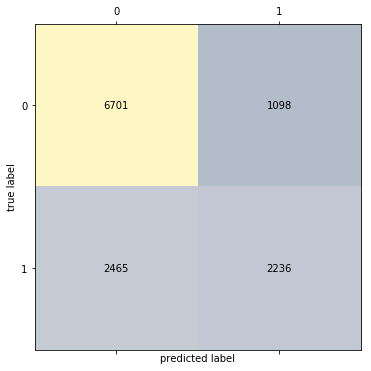

In [140]:
# updated GradientBoostingClassifier model with the optimized parameter
gbc = Pipeline([('scaler', StandardScaler()),('gbc', GradientBoostingClassifier(n_estimators=900, max_features='log2'))])
gbc.fit(X_train, y_train)
pred_train = gbc.predict(X_train)
pred_test = gbc.predict(X_test)

compute_log_result("GradientBoostingClassifier", pred_train, pred_test)

In [141]:
# feature importance ranking from the optimized GradientBoostingClassifier 
feature_rank = pd.DataFrame({'feature': X_train.columns, 'importance': gbc.named_steps.gbc.feature_importances_})
print(feature_rank.sort_values(by='importance',ascending=False))

                   feature  importance
7              weekday_pct    0.233253
8      city_King's Landing    0.153356
4                surge_pct    0.143691
3                avg_surge    0.140524
10            phone_iPhone    0.090681
5   trips_in_first_30_days    0.086321
6      ultimate_black_user    0.082125
0                 avg_dist    0.046072
9          city_Winterfell    0.022353
11     phone_not_available    0.001625
1     avg_rating_by_driver    0.000000
2     avg_rating_of_driver    0.000000


The feature ranking from the optimized classifier suggests that the percent of weekday trips('weekday_pct'), city_King's Landing and "surge_pct" ( the percent of trips taken with surge multiplier > 1 )are the top three factors indicating user retention after 6 month of signing up.

__Conclusion:__

Further investigation to gain valuable insights on why the city 'King's landing' is much more successful at retaining users  and adopting the same policies to cities 'Winterfell' and 'Astapor' might help in user retention.